# Снижение размерности в векторной модели

Входные данные: новостные статьи, их которых предварительно были лемматизированны и очищены от стоп-слов. 

Будем рассматривать два способа снижения размерности:
* Латентно-семантический анализ
* Автоэнкодер 

Будем использовать векторное представление текста: каждый текст – вектор в $N$-мерном пространстве. Ограничим число размерностей до 2000. Будем приводить 2000-мерные вектора к 2-мерным и изображать их на плоскости.

Поскольку мы заранее знаем, к какому разделу относится каждая статья, будем надеяться, что в новом пространстве меньшей размерности мы увидим правильные кластеры статей (1 кластер = 1 раздел). 

Используем:
* pandas для хранения данных и манипуляций с данными и для предварительной обработки;
* seaborn для визуализации;
* gensim для латентно-семантического анализа;
* keras для автоэнкодера.

In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import random
random.seed(1228)
%matplotlib inline

In [2]:
max_words = 3000

Тексты предварительно лемматизированы и очищены от стоп-слов, загружаем их. 

In [5]:
data = pd.read_pickle("/NLP/data/izvestya/articles_lemmatized_no_SW.pkl") 

Посмотрим на первые пять текстов.

In [6]:
data.head()

,headline,body,topic
4069,Теперь подарки можно выбрать на сайте при помо...,поиск подарок любой праздник гораздо просто бл...,IT
1666,Тренды розничной торговли 2016,платформа соцсеть продолжать служить шопинг-пл...,IT
1802,Порталы сравнения цен вынуждают мелких ритейле...,последний время активно расти конкуренция обла...,IT
3784,9 беспроигрышных подарков для мужчины,каждый год накануне февраль возникать сложный ...,IT
2186,Китайские производители сокращают свой бизнес ...,прекращать поставка новый автомобиль дилер рос...,Авто


Посмотрим на некоторые описательные статистики, например, на длину текстов (в словах).

In [5]:
len_data = data['body'].apply(len)

In [6]:
len_data.describe()

count    56500.000000
mean      1577.539929
std       1720.820738
min          0.000000
25%        743.000000
50%       1007.000000
75%       1543.000000
max      65175.000000
Name: body, dtype: float64

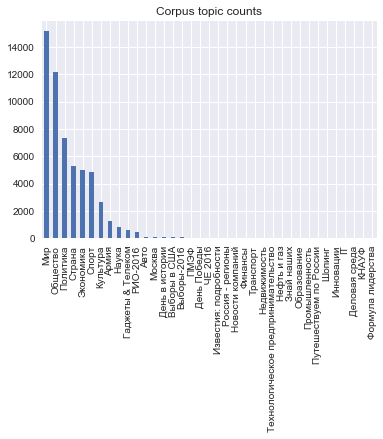

In [7]:
plt.title("Corpus topic counts")
data.topic.value_counts().plot(kind='bar')
plt.figure(figsize=(8, 6))
plt.show()

И на количество текстов. 

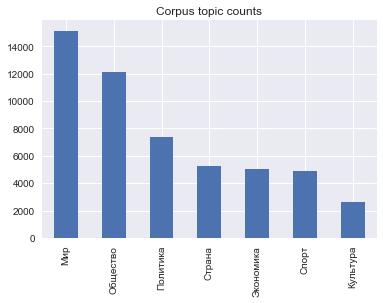

In [8]:
plt.title("Corpus topic counts")
data.topic.value_counts()[data.topic.value_counts() > 2000].plot(kind='bar')
plt.figure(figsize=(8, 6))
plt.show()

Выберем 5 разделов – Культура, Общество, Политика, Экономика и Спорт. Мир и Страна могут дублировать другие разделы, их проигнорируем. Кроме того, возьмем тексты средней длины. 

In [7]:
data = data[data.topic.isin(("Культура", "Общество", "Политика", "Экономика", "Спорт"))] #"Мир", "Страна", 
#data = data[len_data > 1000]
#data = data[len_data < 5000]
print(data.topic.value_counts())

Общество     12147
Политика      7359
Экономика     5032
Спорт         4881
Культура      2635
Name: topic, dtype: int64


In [8]:
data_sample = pd.DataFrame(columns=data.columns)

for topic in data.topic.unique():
    sample = data[data.topic==topic].sample(2500)
    data_sample = data_sample.append(sample)

    
print(data_sample.topic.value_counts())   

Политика     2500
Общество     2500
Спорт        2500
Культура     2500
Экономика    2500
Name: topic, dtype: int64


## Латентно-семантический анализ

Задаем векторное пространство: dictionary – это словарь, в котором хранятся индексы слов, а corpus – вектора, представляюшие тексты в этом пространстве. 

In [9]:
from gensim.corpora import *

texts = [data_sample.body.iloc[i].split() for i in range(len(data_sample))]
dictionary = Dictionary(texts)
dictionary.filter_n_most_frequent(max_words)
corpus = [dictionary.doc2bow(text) for text in texts]

Первый шаг ЛСА – $tf-idf$ взвешивание. 

In [12]:
from gensim.models import *
tfidf = TfidfModel(corpus)
corpus_tfidf = tfidf[corpus]

Найдем две координаты в пространстве меньшей размерности с помощью ЛСА и отобразим их на плоскости. Теперь каждый текст – это 2-мерный вектор, то есть, точка на плоскости. 

In [13]:
lsi = lsimodel.LsiModel(corpus=corpus_tfidf, id2word=dictionary, num_topics=2)

In [14]:
X = [0] * len(data_sample)
Y = [0] * len(data_sample)
for i in range(len(data_sample)):
    vec = corpus[i]
    LSI_topics = (lsi[vec])
    try:
        for topic in LSI_topics:
            if topic[0] == 0:
                if topic[1] < 5:
                    X[i] = topic[1]
                else:
                    continue 
            elif topic[0] == 1:
                Y[i] = topic[1]
    except:
        pass
df = pd.DataFrame({'X': X, 'Y': Y, 'topic' : data_sample.topic})

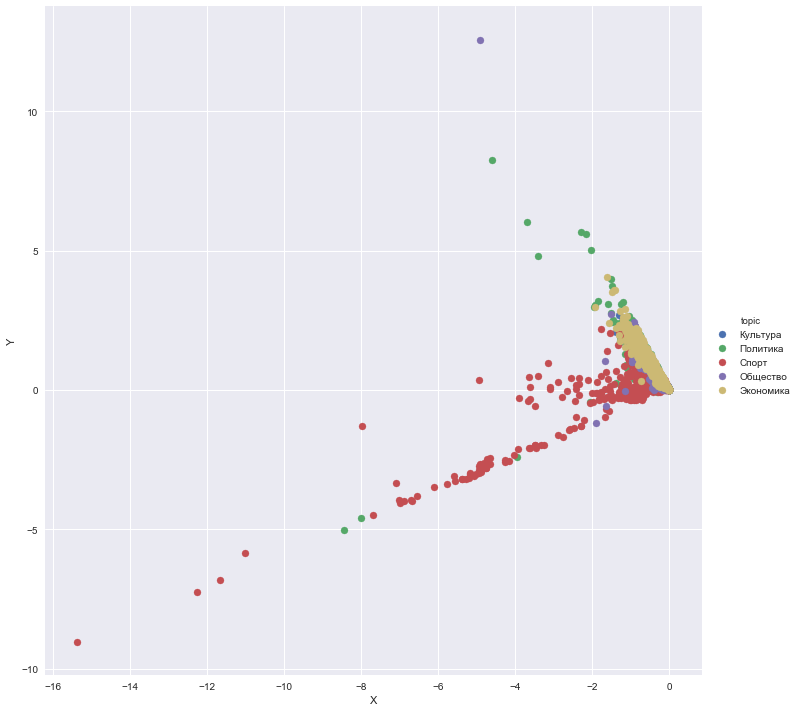

In [15]:
sns.FacetGrid(df, hue="topic", size=10).map(plt.scatter, "X", "Y").add_legend()

# t-SNE

In [16]:
from sklearn.manifold import TSNE
from sklearn.decomposition import TruncatedSVD
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import Normalizer
from sklearn.feature_extraction.text import *

vectors = TfidfVectorizer().fit_transform(data_sample.body)
X_reduced = TruncatedSVD(n_components=100, random_state=0).fit_transform(vectors)
X_embedded = TSNE(n_components=2, perplexity=40, verbose=2).fit_transform(X_reduced)

[t-SNE] Computing pairwise distances...
[t-SNE] Computing 121 nearest neighbors...
[t-SNE] Computed conditional probabilities for sample 1000 / 12500
[t-SNE] Computed conditional probabilities for sample 2000 / 12500
[t-SNE] Computed conditional probabilities for sample 3000 / 12500
[t-SNE] Computed conditional probabilities for sample 4000 / 12500
[t-SNE] Computed conditional probabilities for sample 5000 / 12500
[t-SNE] Computed conditional probabilities for sample 6000 / 12500
[t-SNE] Computed conditional probabilities for sample 7000 / 12500
[t-SNE] Computed conditional probabilities for sample 8000 / 12500
[t-SNE] Computed conditional probabilities for sample 9000 / 12500
[t-SNE] Computed conditional probabilities for sample 10000 / 12500
[t-SNE] Computed conditional probabilities for sample 11000 / 12500
[t-SNE] Computed conditional probabilities for sample 12000 / 12500
[t-SNE] Computed conditional probabilities for sample 12500 / 12500
[t-SNE] Mean sigma: 0.103297
[t-SNE] Itera

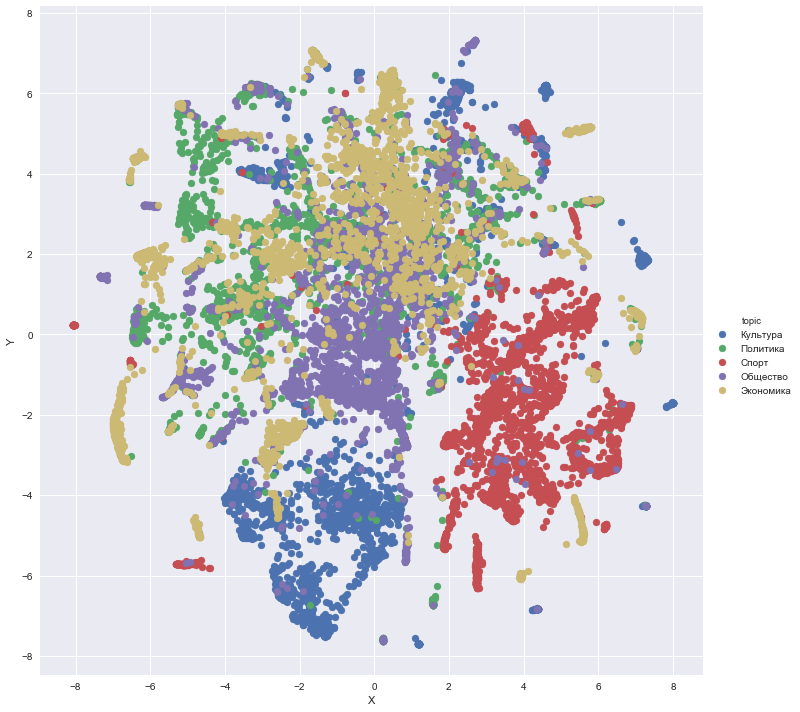

In [17]:
df = pd.DataFrame({'X': X_embedded[:, 0], 'Y': X_embedded[:, 1], 'topic' : data_sample.topic})
sns.FacetGrid(df, hue="topic", size=10).map(plt.scatter, "X", "Y").add_legend()

## Автоэнкодер

Поскольку gensim и keras не умеют взаимодействовать явно, снова зададим векторное пространство собственными силами. 

In [18]:
import nltk
prep_texts = []
ind = {}
fd = nltk.FreqDist()
top100 = []
for text in texts:
    fd.update(text)
# for i in fd.most_common(100):
#     top100.append(i[0])
for i in fd.most_common(max_words):
#     if not i[0] in top100:
    ind[i[0]] = len(ind)
for text in texts:
    prep_text = [0]*max_words
    for word in text:
        if word in ind:
            prep_text[ind[word]] += 1
    prep_texts.append(prep_text)
# for i in top100:
#     print(i)

Представляем вектора входными последовательностями для keras.

In [19]:
from keras.preprocessing import sequence
train_texts = sequence.pad_sequences(prep_texts, maxlen=max_words)

Using TensorFlow backend.


Автоэнкодер состоит из двух частей, энкодера и декодера, каждая из которых построена по схеме 500-250-125-50-10-2. Все функции активации – линейные, функция потерь – величина, обратная косинусной мере близости (то есть, косинусное расстояние). 

In [20]:
from keras import regularizers
from keras.models import Model

from keras.models import Sequential
from keras.layers import Input, Dense, Dropout, Activation, Embedding


encoding_dim = 2

input_text = Input(shape=(max_words,))


enc_dl1 = Dense(500, activation='linear')(input_text)
enc_dl2 = Dense(250, activation='linear')(enc_dl1)
enc_dl3 = Dense(125, activation='linear')(enc_dl2)
enc_dl4 = Dense(50, activation='linear')(enc_dl3)
enc_dl5 = Dense(10, activation='linear')(enc_dl4)

encoded = Dense(encoding_dim, activation='linear')(enc_dl5)


dec_dl1 = Dense(10, activation='linear')(encoded)
dec_dl2 = Dense(50, activation='linear')(dec_dl1)
dec_dl3 = Dense(125, activation='linear')(dec_dl2)
dec_dl4 = Dense(250, activation='linear')(dec_dl3)
dec_dl5  = Dense(500, activation='linear')(dec_dl4)

decoded = Dense(max_words, activation='linear')(dec_dl5)

autoencoder = Model(input=input_text, output=decoded)
autoencoder.compile(optimizer='adam', loss='cosine_proximity')
autoencoder.fit(train_texts, train_texts,
                nb_epoch=30,
                batch_size=128,
                shuffle=True,
                validation_data=(train_texts, train_texts))

Train on 12500 samples, validate on 12500 samples
Epoch 1/30
12500/12500 [==============================] - 19s - loss: -9.9845e-05 - val_loss: -1.1264e-04

Используем энкодер для представления текстов в 2-мерном пространстве и отображаем их на плоскости.  

In [21]:
encoder = Model(input=input_text, output=encoded)
encoded_texts = encoder.predict(train_texts)

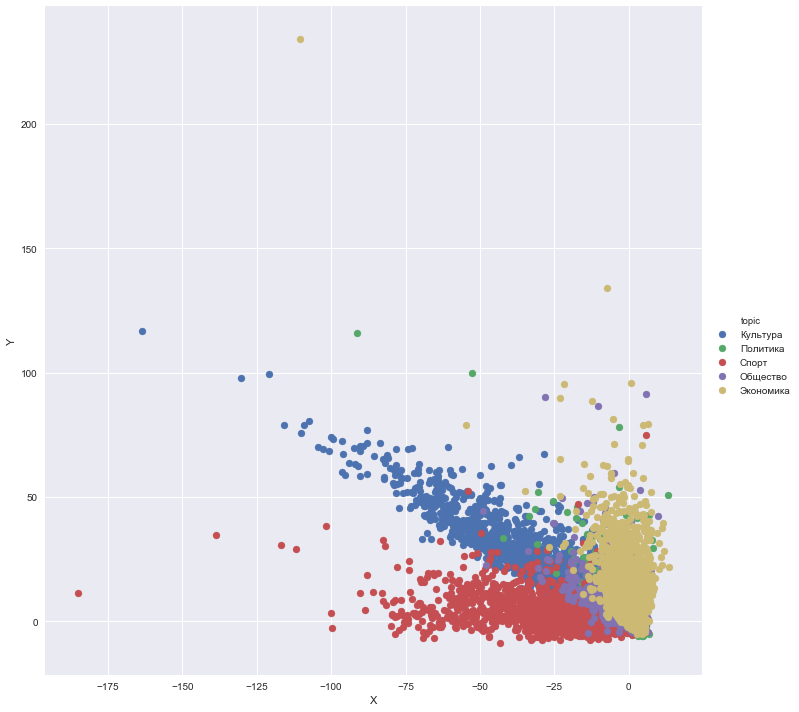

In [22]:
df = pd.DataFrame({'X': encoded_texts[:,0], 'Y': encoded_texts[:,1], 'topic' : data_sample.topic})
sns.FacetGrid(df, hue="topic", size=10).map(plt.scatter, "X", "Y").add_legend()